# **Import Libraries**

In [21]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical


# **Membaca Dataset**

In [3]:
df = pd.read_csv("preprocessed_efootball_reviews.csv")

df.head()

,cleaned_content,score,label,at
0,finally learn play efootball little bite easie...,3,positive,2025-02-20 07:02:41
1,nice game ive play far things make better leag...,5,positive,2025-03-16 19:15:17
2,game serious issue online gameplay match often...,1,negative,2025-04-06 00:56:51
3,game come long way last update enjoyable play ...,3,positive,2025-02-22 10:56:18
4,game pretty good enjoy play vs ai match countr...,2,positive,2025-02-24 09:25:37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31986 entries, 0 to 31985
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cleaned_content  31981 non-null  object
 1   score            31986 non-null  int64 
 2   label            31986 non-null  object
 3   at               31986 non-null  object
dtypes: int64(1), object(3)
memory usage: 999.7+ KB


In [5]:
df.shape

(31986, 4)

# **Membersihkan Dataset**

In [6]:
df.isnull().sum()

,0
cleaned_content,5
score,0
label,0
at,0


In [7]:
df = df.dropna(subset=['cleaned_content'])

In [8]:
df.isnull().sum()

,0
cleaned_content,0
score,0
label,0
at,0


In [9]:
X = df['cleaned_content']
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# **Modelling Skema 1 [Pelatihan: CNN,    Ekstraksi Fitur: Embedding,    Pembagian Data: 80/20]**

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
maxlen = max(len(seq) for seq in X_seq)  # Panjang maksimal teks
X_pad = pad_sequences(X_seq, padding='post', maxlen=100)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_pad, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1

model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_cnn.build(input_shape=(None, maxlen))
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 233, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 229, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 362,411 (1.38 MB)

 Trainable params: 362,411 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_cnn.fit(
              X_train, y_train,
              epochs=100,
              batch_size=32,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping]
          )

# Evaluasi
cnn_pred = model_cnn.predict(X_test).argmax(axis=1)
print(classification_report(y_test, cnn_pred, target_names=le.classes_))

Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.7120 - loss: 0.6586 - val_accuracy: 0.8612 - val_loss: 0.3592
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - accuracy: 0.8657 - loss: 0.3612 - val_accuracy: 0.8645 - val_loss: 0.3381
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.8906 - loss: 0.2985 - val_accuracy: 0.8652 - val_loss: 0.3532
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9135 - loss: 0.2439 - val_accuracy: 0.8704 - val_loss: 0.3530
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.9381 - loss: 0.1912 - val_accuracy: 0.8660 - val_loss: 0.3937
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.9512 - loss: 0.1511 - val_accuracy: 0.8642 - val_loss: 0.4698
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9628 - loss: 0.1173 - val_accuracy: 0.8626 - val_loss: 0.5088
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9647 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Prediksi label untuk data train dan test
cnn_pred_train = model_cnn.predict(X_train).argmax(axis=1)
cnn_pred_test = model_cnn.predict(X_test).argmax(axis=1)

# Hitung akurasi langsung, karena label sudah dalam bentuk angka
accuracy_train_cnn = accuracy_score(y_train, cnn_pred_train)
accuracy_test_cnn = accuracy_score(y_test, cnn_pred_test)

# Tampilkan hasil
print("CNN - akurasi data train:", accuracy_train_cnn)
print("CNN - akurasi data test:", accuracy_test_cnn)

800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
CNN - akurasi data train: 0.9099828017510945
CNN - akurasi data test: 0.8644677192433954


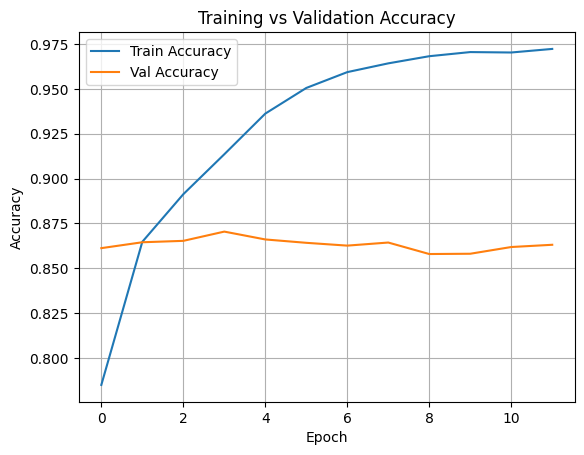

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()

# **Modelling Skema 2 [Pelatihan: SVM,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20]**

In [29]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)

# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train2, y_test2]))
y_train_encoded = label_encoder.transform(y_train2)
y_test_encoded = label_encoder.transform(y_test2)

# SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train2, y_train_encoded)


TF-IDF shape: (31981, 5000)


In [30]:
# Training model SVM
svm_model = SVC(kernel='linear')

start_time = time.time()
svm_model.fit(X_train_resampled, y_train_resampled)
print("Training selesai dalam", round(time.time() - start_time, 2), "detik")

# Prediksi
y_pred_train = svm_model.predict(X_train2)
y_pred_test = svm_model.predict(X_test2)
y_pred_train_original = label_encoder.inverse_transform(y_pred_train)
y_pred_test_original = label_encoder.inverse_transform(y_pred_test)

# Evaluasi
accuracy_train = accuracy_score(y_train2, y_pred_train_original)
accuracy_test = accuracy_score(y_test2, y_pred_test_original)

print('SVM - akurasi data train:', accuracy_train)
print('SVM - akurasi data test:', accuracy_test)

Training selesai dalam 1039.39 detik
SVM - akurasi data train: 0.9097873671044403
SVM - akurasi data test: 0.8457089260590902


# **Modelling Skema 3  [Pelatihan: RF,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20]**

In [17]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)  # Pastikan X adalah kolom teks (misal: df['cleaned_content'])

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [18]:
rf_model_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tfidf.fit(X_train3, y_train3)

# Prediksi dan evaluasi
rf_pred3 = rf_model_tfidf.predict(X_test3)

# Classification report
print(classification_report(y_test3, rf_pred3, target_names=le.classes_))  # le = LabelEncoder()

# Akurasi train dan test
y_pred_train_rf = rf_model_tfidf.predict(X_train3)
y_pred_test_rf = rf_model_tfidf.predict(X_test3)

accuracy_train_rf = accuracy_score(y_train3, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test3, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy train:', accuracy_train_rf)
print('Random Forest - accuracy test :', accuracy_test_rf)

              precision    recall  f1-score   support

    negative       0.82      0.45      0.58      1513
     neutral       1.00      0.01      0.01       150
    positive       0.83      0.97      0.89      4734

    accuracy                           0.83      6397
   macro avg       0.88      0.48      0.50      6397
weighted avg       0.83      0.83      0.80      6397

Random Forest - accuracy train: 1.0
Random Forest - accuracy test : 0.8274191027043927


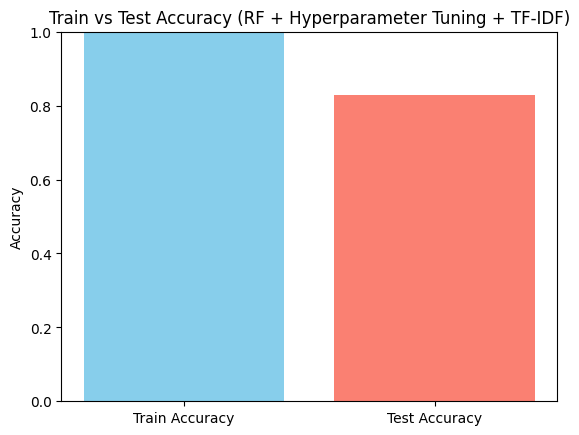

In [19]:
train_accuracy = accuracy_score(y_train3, rf_model_tfidf.predict(X_train3))
test_accuracy = accuracy_score(y_test3, rf_model_tfidf.predict(X_test3))

# Plotting
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['skyblue', 'salmon'])
plt.ylim(0, 1.0)
plt.title('Train vs Test Accuracy (RF + Hyperparameter Tuning + TF-IDF)')
plt.ylabel('Accuracy')
plt.show()

# **Eksport Model**

In [24]:
import joblib

In [ ]:
# Simpan model
joblib.dump(svm_model, 'svm_model.pkl')
print("Model berhasil disimpan ke 'svm_model.pkl'")

joblib.dump(rf_model_tfidf, 'rf_model.pkl')
print("Model berhasil disimpan ke 'rf_model.pkl'")


In [25]:
from google.colab import drive
drive.mount('/content/drive')


# Simpan model
model_cnn.save('/content/drive/MyDrive/cnn_model.h5')
joblib.dump(svm_model, '/content/drive/MyDrive/svm_model.pkl')
joblib.dump(rf_model_tfidf, '/content/drive/MyDrive/rf_model_tfidf.pkl')

joblib.dump(tfidf, '/content/drive/MyDrive/tfidf_vectorizer.pkl')
joblib.dump(tokenizer, '/content/drive/MyDrive/tokenizer.pkl')

print("Model, tfidf, dan tokenizer berhasil diekspor ke Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model dan vectorizer berhasil diekspor ke Google Drive.


Didapatkan bahwa model yang memenuhi syarat adalah model dari skema 1 yakni CNN dengan ekstraksi fitur embedding, dan pembagian data 80/20. Model CNN memperoleh akurasi 90% pada data training dan 86% pada data testing.  Dari beberapa percobaan yang telah dilakukan juga, diketahui model SVM dapat mencapai akurasi 90% pada data training dan 85% pada data testing jika dilatih tanpa membatasi fitur (memberikan max feature pada TF-IDF). Dapat dilihat pada notebook ini, saat pelatihan model SVM menggunakan max feature 5000 didapatkan pengurangan pada akurasi data testing yang turun ke angka 84%.